In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read 
df=pd.read_excel("./data/titanic3.xls", header=0)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   class     1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   int64  
 3   age       1309 non-null   float64
 4   fare      1309 non-null   float64
 5   alone     1309 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 61.5 KB


In [49]:
df.head()

,class,survived,sex,age,fare,alone
0,1,1,1,29.0000,211.3375,1
1,1,1,0,0.9167,151.5500,0
2,1,0,1,2.0000,151.5500,0
3,1,0,0,30.0000,151.5500,0
4,1,0,1,25.0000,151.5500,0


In [50]:
df.describe()

,class,survived,sex,age,fare,alone
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,0.381971,0.355997,29.881135,33.295479,0.603514
std,0.837836,0.486055,0.478997,12.883199,51.738879,0.489354
min,1.000000,0.000000,0.000000,0.166700,0.000000,0.000000
25%,2.000000,0.000000,0.000000,22.000000,7.895800,0.000000
50%,3.000000,0.000000,0.000000,29.881135,14.454200,1.000000
75%,3.000000,1.000000,1.000000,35.000000,31.275000,1.000000
max,3.000000,1.000000,1.000000,80.000000,512.329200,1.000000


Based on the amount of null values we see we can drop cabin, boat, body and home.dest.  
We will also drop name and ticket as this are random, meaningless values.  
The names for pclass (class), sibsp (siblings_spouse), and parch (parents_children) are changed for clarity  
Sex will be stored as a binary value (1 = female, 0 = male)  
siblings_spouse and parents_children are summarized in the column alone (0 = no, 1 = yes)  
Null values in the fare and age are replaced with the mean values 

In [44]:
df.rename(columns={'pclass': 'class', 'sibsp': 'siblings_spouse', 'parch': 'parents_children'}, inplace=True)
df['sex'] = df['sex'].apply(lambda x: 0 if str(x) == 'male' else 1)
df['alone'] = df.apply(lambda row: 1 if row['parents_children'] == 0 and row['siblings_spouse'] == 0 else 0, axis=1)
df['age'].fillna(value=df['age'].mean(), inplace=True)
df['fare'].fillna(value=df['fare'].mean(), inplace=True)
df.drop(['cabin', 'boat', 'body', 'home.dest', 'ticket', 'name', 'siblings_spouse', 'parents_children'], axis=1, inplace=True)



TODO: Jeffrey is doing the age thing

TODO: For now I am dropping embarked because it is categorical which is confusing and Hannah is working on that.

In [45]:
df.drop('embarked', axis=1, inplace=True)

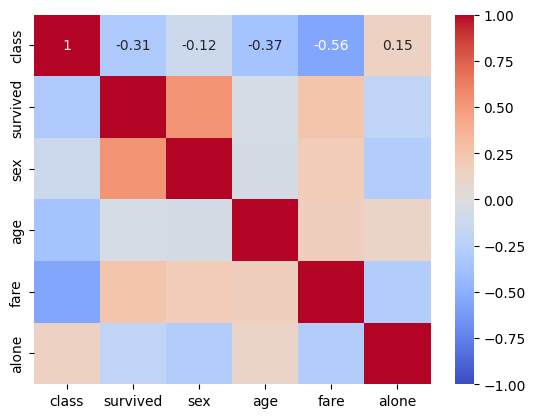

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix
corr = df.corr()

# Create the heatmap
sns.heatmap(corr,
            vmin=-1,
            cmap='coolwarm',
            annot=True);


In [47]:
corr['survived'].sort_values(ascending=False)

survived    1.000000
sex         0.528693
fare        0.244208
age        -0.050199
alone      -0.201719
class      -0.312469
Name: survived, dtype: float64

Based on these correlation values sex, fare, alone, and class seem to be interesting features.  
Let's test these with a decision tree (xgboosted)

In [69]:
# !pip install xgboost
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df.drop(['survived', 'alone'], axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f'Accuracy: {accuracy}')

# Access the feature importance scores
feature_importance = model.feature_importances_

# Create a DataFrame to associate feature names with their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance scores
print(feature_importance_df)

Accuracy: 0.8129770992366412
  Feature  Importance
1     sex    0.697794
0   class    0.219481
3    fare    0.043014
2     age    0.039710


And a random forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Features
X = df.drop('survived', axis=1)

# Target variable (create and populate with real data)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Access the feature importance scores
feature_importance = clf.feature_importances_

# Create a DataFrame to associate feature names with their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance scores
print("Feature Importance Scores:")
print(feature_importance_df)
print(f"Accuracy: {accuracy}")

Feature Importance Scores:
  Feature  Importance
3    fare    0.339147
2     age    0.276858
1     sex    0.271143
0   class    0.090860
4   alone    0.021991
Accuracy: 0.7938931297709924


I believe that the XGBOOST gives better results than the random forest.  
Therefore, I believe we should include sex and class when training the model (and maybe destination/point of arrival depending on Hannah's code).